### Backend

In [10]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

### Set Molecules

In [8]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType


molecule = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["O", [0.0, 0.0, 0.0]],
        ["H", [0.758602, 0.0, 0.504284]],
        ["H", [0.758602, 0.0, -0.504284]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

properties = driver.run()

In [2]:
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")
print(PN_property)

# Define the active space around the Fermi level 
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2, #how many electrons we have in our active space
    num_molecular_orbitals=2, #how many orbitals we have in our active space
)


# We can hand-pick the MOs to be included in the AS
# (in case they are not exactly around the Fermi level)

# transformer = ActiveSpaceTransformer(
#     num_electrons=2, #how many electrons we have in our active space
#     num_molecular_orbitals=2, #how many orbitals we have in our active space
#     active_orbitals=[4,7], #We are specifically choosing MO number 4 (occupied with two electrons) and 7 (empty)
# )

ParticleNumber:
	14 SOs
	5 alpha electrons
		orbital occupation: [1. 1. 1. 1. 1. 0. 0.]
	5 beta electrons
		orbital occupation: [1. 1. 1. 1. 1. 0. 0.]


### Hamiltonian

In [3]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

problem = ElectronicStructureProblem(driver, [transformer])

second_q_ops = problem.second_q_ops() # this calls driver.run() internally

hamiltonian = second_q_ops[0]

print(hamiltonian)

Fermionic Operator
register length=4, number terms=36
  -1.2879605266732743 * ( +_0 -_0 )
+ -0.5749964325186913 * ( +_1 -_1 )
+ -1.2879605266732743 * ( +_2 -_2 )
+ -0.5749964325186913 * ( +_3 -_3 )
+ -0.4400795466875222 * ( +_0 +_0 -_0 -_0 )
+ -0.019 ...


### Qubit Mapping

In [4]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper)

qubit_op = converter.convert(hamiltonian)
print(qubit_op)

-0.8720633572288621 * IIII
+ 0.11923749314031658 * IIIZ
- 0.1786526155074367 * IIZI
+ 0.11923749314031662 * IZII
- 0.1786526155074367 * ZIII
+ 0.1475343334568581 * IIZZ
+ 0.2200397733437611 * IZIZ
+ 0.009634329938843242 * YYYY
+ 0.009634329938843242 * XXYY
+ 0.009634329938843242 * YYXX
+ 0.009634329938843242 * XXXX
+ 0.15716866339570135 * ZIIZ
+ 0.15716866339570135 * IZZI
+ 0.16144783491422288 * ZIZI
+ 0.1475343334568581 * ZZII


### Initial State

In [5]:
from qiskit_nature.circuit.library import HartreeFock

particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_spin_orbitals = particle_number.num_spin_orbitals
num_particles = particle_number.num_particles


init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


#### Ansatz

In [7]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "TwoLocal"


# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cz'
    # How the qubits are entangled 
    entanglement = 'full'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

print(ansatz.decompose())

     ┌───────────┐┌──────────┐┌──────────┐                  
q_0: ┤ U3(π,0,π) ├┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├─■──■─────■───────
     └┬──────────┤├──────────┤└──────────┘ │  │     │       
q_1: ─┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├─────────────■──┼──■──┼──■────
     ┌┴──────────┤├──────────┤┌──────────┐    │  │  │  │    
q_2: ┤ U3(π,0,π) ├┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├────■──■──┼──┼──■─
     └┬──────────┤├──────────┤└──────────┘          │  │  │ 
q_3: ─┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├──────────────────────■──■──■─
      └──────────┘└──────────┘                              


#### Optimizer

In [9]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'L_BFGS_B'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

### Exact Result

In [11]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

# The targeted electronic energy for H2 is -1.85336 Ha
# Check with your VQE result.

Exact electronic energy -1.6970070288529018
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.700895930366
  - computed part:      -1.697007028853
  - ActiveSpaceTransformer extracted energy part: -83.003888901513
~ Nuclear repulsion energy (Hartree): 9.819476509782
> Total ground state energy (Hartree): -74.881419420584
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.86710004  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [2.0649676  0.0  0.0]
    - computed part:      [0.0022825  0.0  0.0]
    - ActiveSpaceTransformer extracted energy part: [2.0626851  0.0  0.0]
  > Dipole moment (a.u.): [0.80213244  0.0  0.0]  Total: 0.80213244
                 (debye): [2.0388171  0.0  0.0]  Total: 2.0388171
 


### Run QVE

In [12]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 45,
    'eigenstate': array([-4.23116430e-15+8.46344497e-17j, -6.69635806e-08+6.69660750e-10j,
       -4.12238519e-22+4.12247851e-24j,  6.52354875e-15+2.55398185e-22j,
        6.31923718e-08-6.31947257e-10j, -1.00000000e+00+1.06940596e-07j,
       -6.15616002e-15-2.41014847e-22j, -9.74096122e-08-9.74125803e-10j,
       -2.01395347e-22+2.01401484e-24j,  3.18701991e-15-1.24772436e-22j,
        1.96198046e-29+2.09815363e-36j,  3.10446374e-22+3.10457938e-24j,
       -3.00753552e-15+1.17745588e-22j, -4.75885727e-08-4.75896501e-10j,
       -2.92962868e-22-2.92973781e-24j,  4.63512082e-15+9.27146459e-17j]),
    'eigenvalue': (-1.6957619599714928+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[7]): 0.01,
                              ParameterVectorElement(θ[6]): 0.009999932209593953,
                              ParameterVectorElement(θ[2]): 1.339338578834181e-07,
                              ParameterVectorElement

/tmp/ipykernel_6761/2841387939.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append([result_dict])


,optimizer,ansatz,rotation blocks,entanglement_blocks,entanglement,repetitions,# of qubits,# of parameters,# of CNOTs,# of evaluations,error (mHa)
0,L_BFGS_B,TwoLocal,"['ry', 'rz']",cz,full,1.0,4,8,6,45,1.245069e+00
1,L_BFGS_B,UCCSD,NaN,NaN,NaN,NaN,4,3,56,28,1.330047e-10
2,L_BFGS_B,PUCCD,NaN,NaN,NaN,NaN,4,1,48,8,3.021139e-09
3,L_BFGS_B,SUCCD,NaN,NaN,NaN,NaN,4,1,48,8,3.015810e-09
4,L_BFGS_B,QuantumCircuit,NaN,NaN,NaN,NaN,4,1,3,2,4.241874e+02
5,L_BFGS_B,QuantumCircuit,NaN,NaN,NaN,NaN,4,1,3,2,4.241874e+02
6,L_BFGS_B,TwoLocal,"['ry', 'rz']",cz,full,1.0,4,8,6,45,1.245069e+00
0,L_BFGS_B,TwoLocal,"[ry, rz]",cz,full,1.0,4,8,6,45,1.245069e+00


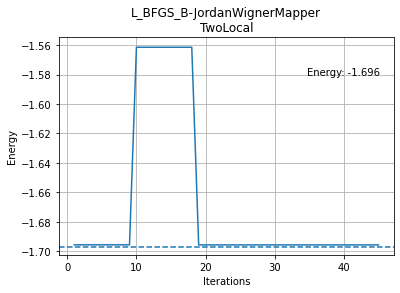

In [15]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']

energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.cost_function_evals,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.cost_function_evals,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f}).png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2o.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', 'rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', '# of qubits', '# of parameters', '# of CNOTs', '# of evaluations', 'error (mHa)']]

In [17]:
print(os.path)

<module 'posixpath' from '/home/abdurrahmanws/miniconda3/envs/qc/lib/python3.10/posixpath.py'>
